# Rec iterative

In [1]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S
from holotomocupy.chunking import gpu_batch
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.proc import dai_yuan, linear
from holotomocupy.utils import *
import holotomocupy.chunking as chunking

%matplotlib inline

chunking.global_chunk = 60 # chunk for GPU processing

astropy module not found
olefile module not found


In [ ]:
# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 256  # object size in each dimension
ntheta = 180  # number of angles (rotations)

center = n/2  # rotation axis
theta = cp.linspace(0, np.pi, ntheta).astype('float32')  # projection angles


npos = 1  # number of code positions 

detector_pixelsize = 3e-6*0.5
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length

focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0#np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1,[npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = 12e-3  # positions of the code and the probe for reconstruction

z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1p
# propagation distances after switching from the point source wave to plane wave,
distances2 = (z1p*z2p)/(z1p+z2p)
norm_magnifications2 = magnifications2/(z1p/z1[0])  # normalized magnifications
# scaled propagation distances due to magnified probes
distances2 = distances2*norm_magnifications2**2
distances2 = distances2*(z1p/z1)**2

# allow padding if there are shifts of the probe
pad = n//16*0
# sample size after demagnification
ne = n+2*pad


In [ ]:
### Read data

In [3]:
data00 = np.zeros([ntheta, npos, n, n], dtype='float32')

for k in range(npos):
    data00[:, k] = read_tiff(f'data/data_{n}_{k}.tiff')[:ntheta]
code = np.load('data/code.npy')
shifts_code = np.load('data/shifts_code.npy')[:, :npos]

In [ ]:
### Show an example of data and the code

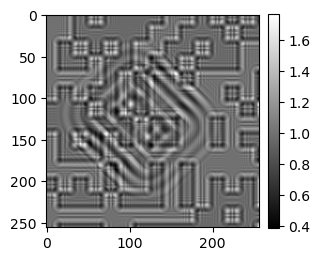

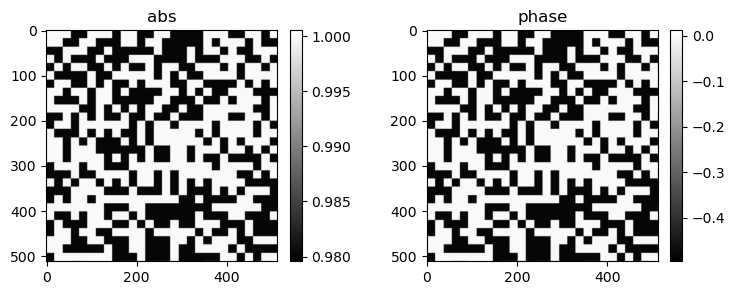

In [4]:
mshow(data00[0,0])
mshow_polar(code[0])

In [ ]:
# Construct operators


In [ ]:
#### Forward holo: $d=\mathcal{G}_{z}\left(\mathcal{G}_{z'}(q(\mathcal{S}_{s_{j}}c))\psi\right)$,
#### Adjoint holo: $\psi=\sum_j\left((\mathcal{G}_{z_j'}(q\mathcal{S}_{s'_{kj}}c))^*\mathcal{G}^H_{z}d\right)$.




In [5]:
@gpu_batch
def _fwd_holo(psi, shifts_code, code, prb):
    prb = cp.array(prb)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        # ill shift for each acquisition
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])
        # code shift for each acquisition
        coder = cp.tile(code, [psi.shape[0], 1, 1])
        coder = S(coder, shifts_code[:, i])

        coder = coder[:, ne-n//2-pad:ne+n//2+pad, ne-n//2-pad:ne+n//2+pad]

        # multiply the code and ill
        prbr *= coder
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[i])

        psir = psi.copy()

        # multiply the ill and object
        psir *= prbr

        # propagate both
        psir = G(psir, wavelength, voxelsize, distances[i])
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data


def fwd_holo(psi, prb):
    return _fwd_holo(psi, shifts_code, code, prb)


@gpu_batch
def _adj_holo(data, shifts_code, code, prb):
    prb = cp.array(prb)
    code = cp.array(code)
    shifts_code = cp.array(shifts_code)
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')
    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad)))

        # propagate data back
        psir = GT(psir, wavelength, voxelsize, distances[j])

        # ill shift for each acquisition
        prbr = cp.tile(prb, [psi.shape[0], 1, 1])
        # code shift for each acquisition
        coder = cp.tile(code, [psi.shape[0], 1, 1])

        coder = S(coder, shifts_code[:, j])
        coder = coder[:, ne-n//2-pad:ne+n//2+pad, ne-n//2-pad:ne+n//2+pad]
        # multiply the code and ill
        prbr *= coder
        # propagate illumination
        prbr = G(prbr, wavelength, voxelsize, distances2[j])

        # multiply the conj ill and object
        psir *= cp.conj(prbr)

        # object shift for each acquisition
        psi += psir
    return psi


def adj_holo(data, prb):
    return _adj_holo(data, shifts_code, code, prb)


# adjoint test
data = data00.copy()
arr1 = np.pad(np.array(data[:, 0]+1j*data[:, 0]).astype('complex64'),
              ((0, 0), (ne//2-n//2, ne//2-n//2), (ne//2-n//2, ne//2-n//2)), 'symmetric')
prb1 = np.ones([1, n+2*pad, n+2*pad], dtype='complex64')
arr2 = fwd_holo(arr1, prb1)
arr3 = adj_holo(arr2, prb1)

print(f'{np.sum(arr1*np.conj(arr3))}==\n{np.sum(arr2*np.conj(arr2))}')

(22267118-0.0851115733385086j)==
(22267114+2.0059762391611002e-05j)


In [ ]:
### Propagate the code to the detector and divide all data by it

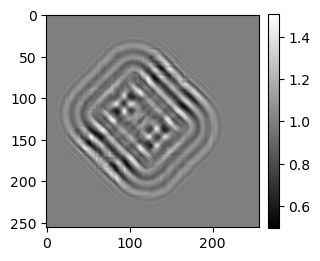

In [6]:

psi = np.ones([ntheta,ne,ne],dtype='complex64')
prb = np.ones([1,n+2*pad,n+2*pad],dtype='complex64')
d = np.abs(fwd_holo(psi,prb))**2

rdata = data00/d
mshow(rdata[0,0])

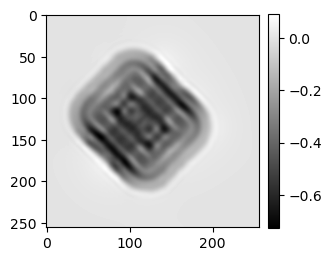

In [7]:
# distances should not be normalized
distances_pag = (distances/norm_magnifications**2)[:npos]
recMultiPaganin = np.exp(1j*multiPaganin(rdata,
                         distances_pag, wavelength, voxelsize,  100, 1e-12))
mshow(np.angle(recMultiPaganin[0]))

In [ ]:
#### Main reconstruction. $\left\||\mathcal{G}_{z}(\mathcal{G}_{z'}(q\mathcal{S}_{s_{j}}c)\psi)|-\sqrt{d}\right\|_2^2\to min$

0) gamma=0.5, err=8.01275e+02


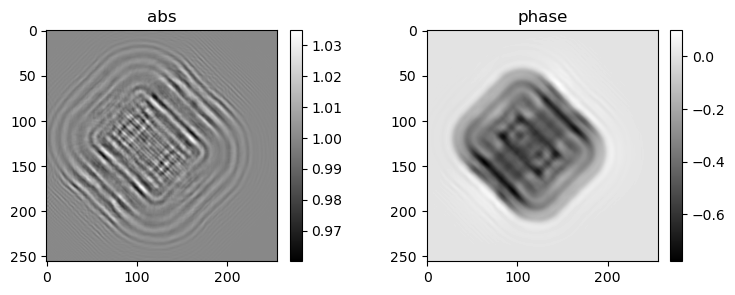

4) gamma=0.5, err=5.74570e-02
8) gamma=0.5, err=1.03039e-05
12) gamma=0.5, err=2.45755e-07


In [8]:
def line_search(minf, gamma, fu, fd):
    """ Line search for the step sizes gamma"""
    while (minf(fu)-minf(fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if (gamma <= 1e-12):  # direction not found
        # print('no direction')
        gamma = 0
    return gamma


def cg_holo(data, init_psi,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fpsi):
        f = np.linalg.norm(np.abs(fpsi)-data)**2
        return f

    data = np.sqrt(data)
    psi = init_psi.copy()

    for i in range(pars['niter']):
        # Calculate the gradient
        fpsi = fwd_holo(psi, prb)
        grad = adj_holo(fpsi-data*np.exp(1j*np.angle(fpsi)), prb)

        # Dai-Yuan direction for the CG solver
        if i == 0:
            d = -grad
        else:
            d = dai_yuan(d, grad, grad0)
        grad0 = grad

        # line search
        fd = fwd_holo(d, prb)
        gamma = line_search(minf, pars['gammapsi'], fpsi, fd)

        # update psi
        psi += gamma*d

        if i % pars['err_step'] == 0:
            fpsi = fwd_holo(psi, prb)
            err = minf(fpsi)
            print(f'{i}) {gamma=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow_polar(psi[0])

    return psi


# chunks on gpu - SLOWER
rec_psi = np.pad(recMultiPaganin, ((0, 0), (ne//2-n//2, ne//2-n//2), (ne//2-n//2, ne//2-n//2)), 'edge')
data = data00.copy()


# fully on gpu - FASTER
# rec_psi = cp.array(np.pad(recMultiPaganin, ((
#     0, 0), (ne//2-n//2, ne//2-n//2), (ne//2-n//2, ne//2-n//2)), 'edge'))
# data = cp.array(data00.copy())

pars = {'niter': 16, 'err_step': 4, 'vis_step': 16, 'gammapsi': 0.5}
rec_psi = cg_holo(data, rec_psi, pars)

In [9]:
write_tiff(np.abs(rec_psi),'data/rec_abs')
write_tiff(np.angle(rec_psi),'data/rec_angle')